In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

import scanpy as sc
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

result_dir = './recode/Simulation2/'
data_dir = './data/Simulation2/'

data_ids = os.listdir(result_dir)
softs = ['spanve-k','spanve-d','sepal','somde','moran','geary','r-gitto-sirank','r-sparkx','r-gitto-rank','r-meringue','spatialde'] 


index_cols = defaultdict(int)
index_cols.update({
    "r-gitto-rank":1,
    'r-gitto-sirank':1,
    'somde':3,
    'spatialde':3
})

p_use_columns = {
    "geary":"pval_norm", # include nan can cause bh-adjusted all nan 
    "moran":"pval_norm", # include nan can cause bh-adjusted all nan 
    "r-gitto-rank":"adj.p.value",
    "r-sparkx":"adjustedPval",
    'somde':'qval',
    'spatialde':'qval',
    'spanve-d':'fdrs',
    'spanve-k':'fdrs',
    'r-meringue':'p.adj'
}
score_use_columns = {
    'r-gitto-sirank':'scores',
    'sepal':'average',
}


def parse_file(data_dir,soft):
    path = os.path.join(result_dir,data_dir,soft)
    file = [i for i in os.listdir(path) if i.endswith('csv')][0]
    file = os.path.join(path,file)
    if soft not in p_use_columns:
        use_col = score_use_columns[soft]
    elif soft in p_use_columns:
        use_col = p_use_columns[soft]
    else: print(soft)
        
    df = pd.read_csv(file,index_col=index_cols[soft])[use_col]
    df.name = soft

    return df

In [123]:
from sklearn.metrics import accuracy_score,f1_score

def get_recoder(metrics_func=accuracy_score):
    recoder = pd.DataFrame(columns = ['data','soft','randomness','sparisity','score'])

    for data_id in data_ids:
        df_datares = pd.concat(
            [parse_file(data_id,soft) for soft in softs],
            axis=1
        )
        
        for ps in p_use_columns:
            df_datares[ps] = df_datares[ps].fillna(1)
        for ss in score_use_columns:
            if ss == 'sepal':df_datares[ps] = df_datares[ps].fillna(1);continue
            df_datares[ps] = df_datares[ps].fillna(0)
        
        # df_datares['r-gitto-rank'] = 1-df_datares['r-gitto-rank']
        # df_datares['r-meringue'] = 1-df_datares['r-meringue']
        df_datares['sepal'] = 1-df_datares['sepal']

        r = float(data_id.split('_')[2])
        n = float(data_id.split('_')[1])

        if r > 1.5: continue
        for soft in df_datares.columns:

            if soft in ['moran','geary']:
                reject,fdrs,_,_ = multipletests(df_datares[soft])
                pred = fdrs<0.05
            elif soft in p_use_columns:
                pred = df_datares[soft]<0.05 if soft in p_use_columns else df_datares[soft]>=df_datares[soft].sort_values()[-10]
            elif soft in score_use_columns:
                thres = df_datares[soft].sort_values(ascending=False)[10]
                pred = df_datares[soft]>thres
                
            score = metrics_func([1]*10+[0]*90,pred)

            recoder.loc[len(recoder),:] = data_id,soft,r,n,score
    
    recoder['soft'] = recoder['soft'].map({
        'spanve-k':'Spanve-k',
        'spanve-d':'Spanve-d',
        'somde':'SOMDE',
        'moran':'Moran test',
        'geary':'Geary test',
        'r-sparkx':'SPARK-X',
        'r-gitto-rank':'Gitto-Rank',
        'sepal':'sepal*',
        'r-gitto-sirank':'Gitto-siRank*',
        'spatialde':'SpatialDE',
        'r-meringue':"MERIINGUE"})
    return recoder#,df_datares

Text(0, 0.5, 'F1-score')

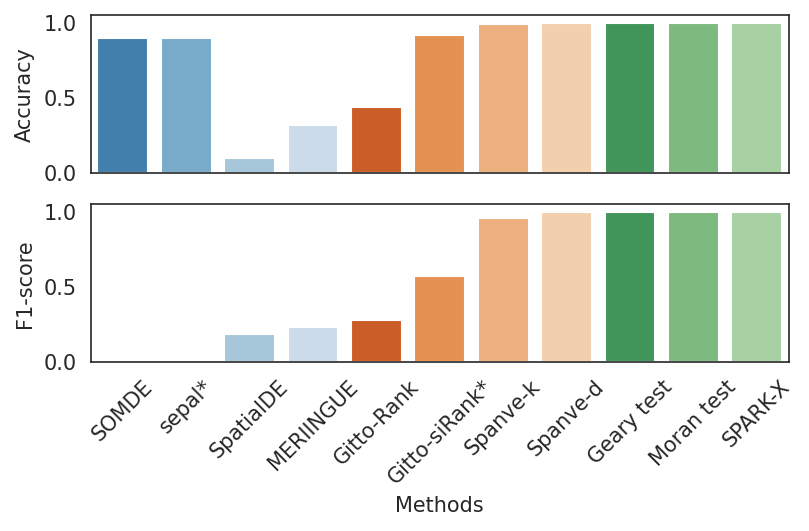

In [124]:
recoder_acc = get_recoder()
recoder_f1 = get_recoder(f1_score)
order = recoder_f1.groupby('soft')['score'].mean().sort_values().index

f,axes = plt.subplots(2,1,dpi=150,figsize=(6,3))

ax = sns.barplot(
    data = recoder_acc,
    x='soft',y='score',#hue='randomness',
    order = order,capsize=0,errwidth=0,
    palette = 'tab20c',ax=axes[0]
)
# ax.set_ylim(0.6,1.05)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('Accuracy')

ax = sns.barplot(
    data = recoder_f1,
    x='soft',y='score',#hue='randomness',
    order = order,capsize=0,errwidth=0,
    palette = 'tab20c',ax=axes[1]
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('Methods')
ax.set_ylabel('F1-score')

In [125]:
f.savefig('./Results/SimulationACC.pdf',bbox_inches='tight')

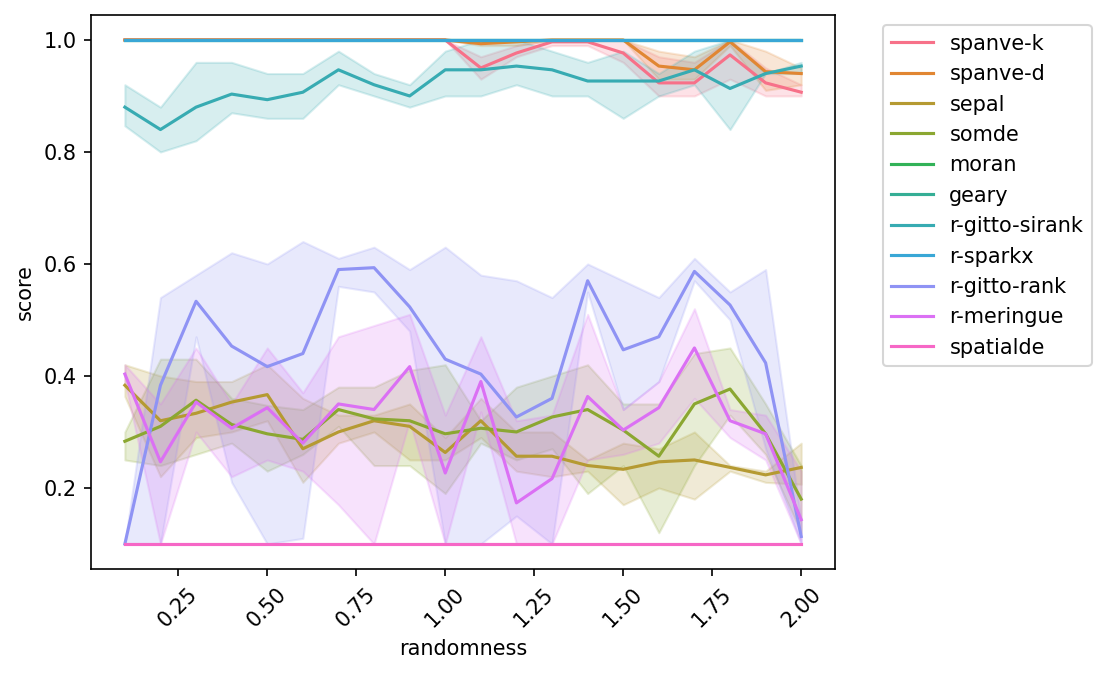

In [30]:
f,ax = plt.subplots(1,1,dpi=150)
ax = sns.lineplot(
    data = recoder,
    # x='soft',y='score',hue='randomness',
    x='randomness',y='score',hue='soft',
    #order = order
)
# ax.set_ylim(0.5,1.05)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(bbox_to_anchor=[1.05,1])